In [1]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import random
import time
import pickle

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

from helper_functions import *
%matplotlib inline

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


#### Some helper functions

In [2]:
def get_image_list(type='both'):
    vehicles = glob.glob('./vehicles/*.png')
    if type=='cars':
        return vehicles
    
    nonvehicles = glob.glob('./non-vehicles/*.png')
    if type == 'noncars':
        return nonvehicles
    
    random.shuffle(vehicles)
    random.shuffle(nonvehicles)
    return vehicles, nonvehicles

def get_random_list(type='both', nsamples = 1000):
    # Images with cars in them
    vehicles = glob.glob('./vehicles/*.png')
    # Images without cars in them
    nonvehicles = glob.glob('./non-vehicles/*.png')
    
    random_idxs_cars = np.random.randint(0, len(vehicles), nsamples)
    random_idxs_noncars = np.random.randint(0, len(nonvehicles), nsamples)

    if type=='cars':
        return np.array(vehicles)[random_idxs_cars]
    
    if type == 'noncars':
        
        return np.array(nonvehicles)[random_idxs_noncars]
    
    return np.array(vehicles)[random_idxs_cars], np.array(nonvehicles)[random_idxs_noncars]
    

def display_sidebyside(image1, title1, image2, title2, cmap='hot'):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    f.tight_layout()
    ax1.imshow(image1, cmap=cmap)
    ax1.set_title(title1, fontsize=12)
    ax2.imshow(image2, cmap=cmap)
    ax2.set_title(title2, fontsize=12)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0., hspace=2)
                

## Check the input data
Before performing the following step, I batch renames the images in individual folders and moved them to the root of ./vehicles and ./non-vehicles

Number of car images: 8792 and shape: (64, 64, 3)
Number of non-car images: 8968 and shape: (64, 64, 3)


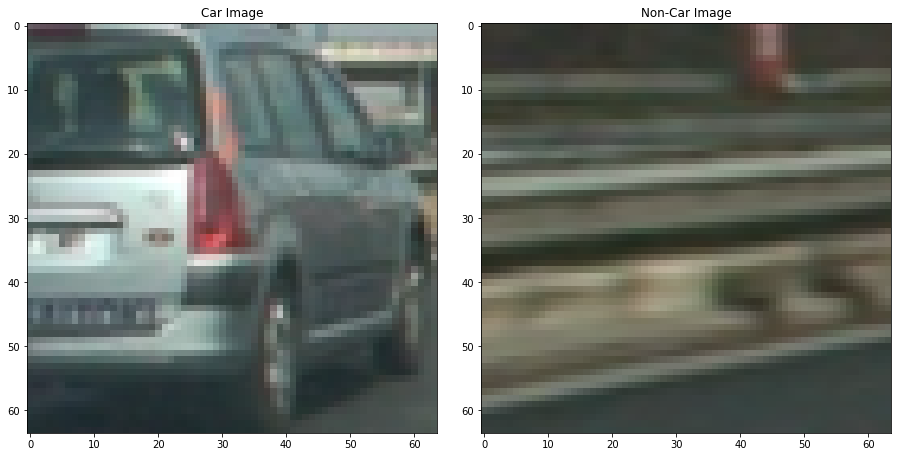

In [3]:
vehicles, nonvehicles = get_image_list()

vehicle_ind = np.random.randint(0, len(vehicles))
nonvehicle_ind = np.random.randint(0, len(nonvehicles))
# REMEMBER - the scaling range here will be 0-1
car_img = mpimg.imread(vehicles[vehicle_ind])
noncar_img = mpimg.imread(nonvehicles[nonvehicle_ind])

print('Number of car images: {} and shape: {}'.format(len(vehicles), car_img.shape))
print('Number of non-car images: {} and shape: {}'.format(len(nonvehicles), noncar_img.shape))




display_sidebyside(car_img, "Car Image", noncar_img, "Non-Car Image")

## Single Image Feature Extraction
I have extracted some features for the above images and displayed them below
The hog representation seems to be consistent with the shape of the car. Specially for the high contrast input images. i.e. in the images where car clearly stands out from the background

feature extraction completed.


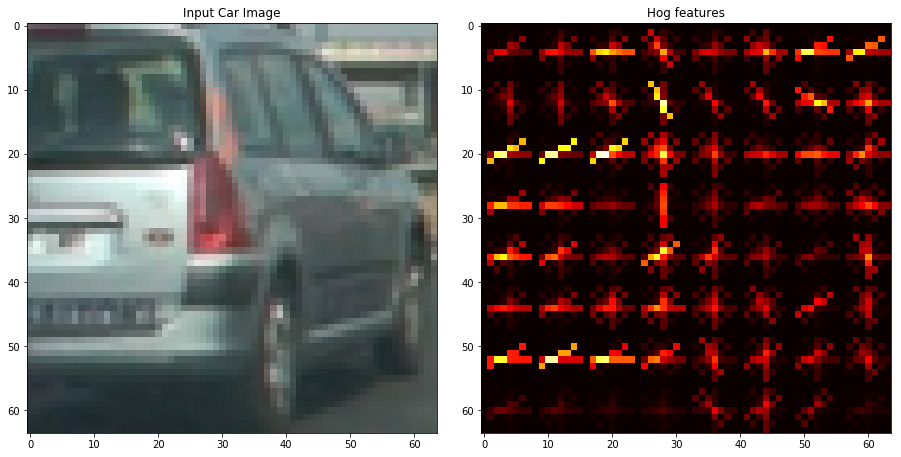

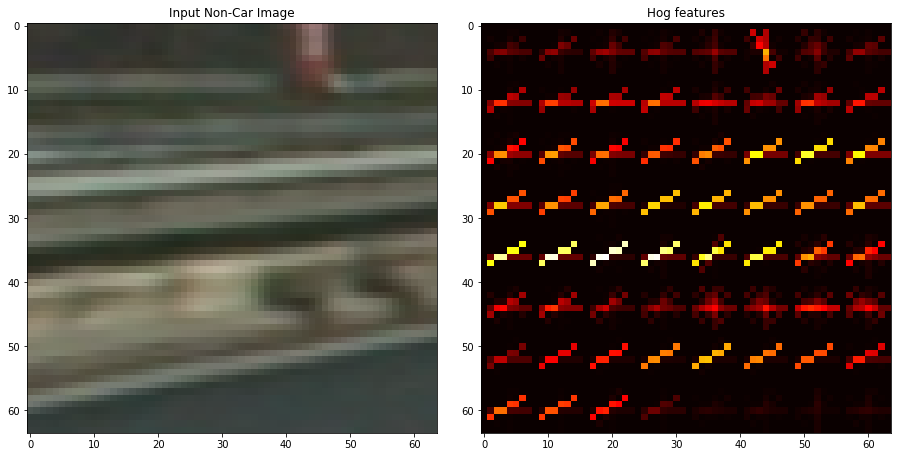

In [4]:
# Feature extraction parameters:
color_space='RGB' # This is the color space that'd be used for feature extraction
spatial_size= (16, 16) # This is the size to which the image will be resized
hist_bins= 16 # Number of bins in the color histogram
orient= 6 # Number of orientation bins
pix_per_cell= 8 # pixels per cell
cell_per_block= 2 # Number of cells in each block
hog_channel= 0 # which channel of image to extract the hog features for
spatial_feat= True # Whether we want to extract spatial features using binning
hist_feat= True # Whether we want to extract color histogram features
hog_feat= True # Whether we want to extract hog features
vis = True
            
# Extract spatial, color histogram and hog features for the car image
car_features, car_hog_img = single_img_features(car_img, color_space, spatial_size,hist_bins, orient,
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat, vis)

display_sidebyside(car_img, "Input Car Image", car_hog_img, "Hog features")

# Extract spatial, color histogram and hog features for non car image
noncar_features, noncar_hog_img = single_img_features(noncar_img, color_space, spatial_size,
                        hist_bins, orient,
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat, vis)
display_sidebyside(noncar_img, "Input Non-Car Image", noncar_hog_img, "Hog features")
print('feature extraction completed.')

## Training a classifier on partial dataset
I am using a 1000 random images from each of the two datasets and training the linear SVM classifier. Following values were observed:
- For orient = 6,  hist_bins= 16 and hog_channel = 0
    - Test Accuracy of SVC with RGB =  93%
    - Test Accuracy of SVC with LUV =  97%
    - Test Accuracy of SVC with HLS =  97.75%
    - Test Accuracy of SVC with HSV =  98%
    - Test Accuracy of SVC with YUV =  98.75%
- For orient = 9, hist_bins= 32 and hog_channel = 'ALL'
    - Test Accuracy of SVC with RGB =  96.5%
    - Test Accuracy of SVC with LUV =  99% (hog_channel = 0 had to be set, because of the sqrt error)
    - Test Accuracy of SVC with HLS =  98.25%
    - **Test Accuracy of SVC with HSV =  99.75%**
    - Test Accuracy of SVC with YUV =  98% (hog_channel = 0 had to be set, because of the sqrt error)
    
 The conclusion from above experimentation is that:
 - We can run into errors due to processing that involves taking square roots of negative numbers, when we use hog_channel='ALL' (i.e. extract features for all 3 channels for a given color space). These errors were seen to be popping up when using YUV and LUV color channels
 - For orient = 9, hist_bins= 32 and hog_channel = 'ALL', HSV color space gives the best accuracy for randomly selected 1000 training and validation samples

In [5]:
def get_feature_extraction_params():
# Feature extraction parameters:
    color_space='YCrCb' # This is the color space that'd be used for feature extraction
    spatial_size= (32,32) # This is the size to which the image will be resized
    hist_bins= 16 # Number of bins in the color histogram
    orient= 9 #Number of orientation bins
    pix_per_cell= 8 # pixels per cell
    cell_per_block= 2 # Number of cells in each block
    hog_channel= 'ALL' # which channel of image to extract the hog features for
    spatial_feat= True # Whether we want to extract spatial features using binning
    hist_feat= True # Whether we want to extract color histogram features
    hog_feat= True # Whether we want to extract hog features
    vis = True
    return color_space, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat, vis

def extract_features_and_train_svm(vehicles_dataset, nonvehicles_dataset):

    color_space, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat, vis = get_feature_extraction_params()
    
    starttime = time.time()

    car_features = extract_features(vehicles_dataset, color_space, spatial_size,
                            hist_bins, orient,
                            pix_per_cell, cell_per_block, hog_channel,
                            spatial_feat=True, hist_feat=True, hog_feat=True)

    notcar_features = extract_features(nonvehicles_dataset, color_space, spatial_size,
                            hist_bins, orient,
                            pix_per_cell, cell_per_block, hog_channel,
                            spatial_feat=True, hist_feat=True, hog_feat=True)

    t_feature_extraction = round(time.time()- starttime, 2)

    # Stack the features from each extraction result to form features vector
    X = np.vstack((car_features, notcar_features)).astype(np.float64)

    # normalize the features
    X_scalar = StandardScaler().fit(X)

    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)

    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    # Use a linear SVC
    svc = LinearSVC()
    # Check the training time for the SVC
    training_start =time.time()
    svc.fit(X_train, y_train)
    training_finish = time.time()
    t_training = round(training_finish-training_start, 2)
    # Check the score of the SVC
    svc_accurary = round(svc.score(X_test, y_test), 4)
    
    return t_feature_extraction, t_training, svc_accurary, svc, X_scaler
    
nsamples = 1000
vehicles_dataset, nonvehicles_dataset = get_random_list(nsamples)
t_feature_extraction, t_training, svc_accurary, svc, X_scaler = extract_features_and_train_svm(vehicles_dataset, nonvehicles_dataset)
print('Feature extraction took:{} seconds'.format(t_feature_extraction))
print('Training took:{} seconds'.format(t_training))
print('Training accuracy:{} %'.format(svc_accurary*100))



Feature extraction took:14.59 seconds
Training took:2.71 seconds
Training accuracy:98.25 %


In [6]:
print("this will just error out here")

this will just error out here


## Training with entire dataset
With the result samples above, we can now train the entire dataset as below:

In [7]:
print("Training with entire dataset...")
vehicles_dataset, nonvehicles_dataset = get_image_list()
t_feature_extraction, t_training, svc_accurary, svc, X_scaler = extract_features_and_train_svm(vehicles_dataset, nonvehicles_dataset)
print('Feature extraction took:{} seconds'.format(t_feature_extraction))
print('Training took:{} seconds'.format(t_training))
print('Training accuracy:{} %'.format(svc_accurary*100))

Training with entire dataset...
Feature extraction took:113.83 seconds
Training took:25.71 seconds
Training accuracy:99.18 %


## Save the training results for later use
I have pickled the trained classifier and X_scalar for later use, so that the cells below this cell can be executed without having to train the model repeatedly.

In [8]:
# Pickle the training results:
svc_pickle = {}
svc_pickle["svc"] = svc
svc_pickle["X_scaler"] = X_scaler
pickle.dump( svc_pickle, open( "svc_pickle/svc_pickle.p", "wb" ) )
print("Done saving...")

Done saving...
